# Statistical financial models

Asset pricing models are a key area of financial research, with broad applcations in risk management, asset allocation and market valuations. In this course, we examine the various statistical models used in trading strategies and portfolio theory. In particular, the Capital Asset Pricing Model (CAPM) will be an area of focus.

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels import regression
import matplotlib
import matplotlib.pyplot as plt

import finance.utils as ut

%matplotlib inline

sns.set_style(  
    "whitegrid",  
    {  
        'legend.frameon': True,  
    }  
)
matplotlib.rc('figure', figsize=(14, 8))

## The capital asset pricing model (CAPM)

The Capital Asset Pricing Model (CAPM) is a classic measure of the cost of capital. It is used often in finance to evaluate the price of assets and to assess the impact of the risk premium from the market at large. 

In general, portfolios and assets face two types of risk: idiosyncratic and systematic risk. Idiosyncratic risk refers to risks that are firm-specific and can be diversified away, such as a management change or faulty production, whereas systematic risk is market-wide and affects all market participants. An example of systematic risk is a slowing of the economy or a change in the interest rate. Because all firms are exposed to systematic risk, it cannot be diversified away.

As we cannot remove systematic risk, investors are given a risk premium above the risk-free rate of return to compensate them for the risk they take on in investing in a portfolio.

In the CAPM, we say that the return of an asset should be the risk-free rate, which is what we would demand to account for inflation and the time value of money, as well as something extra to compensate us for the amount of systematic risk we are exposed to.

We measure the systematic risk for the asset by computing its beta against a market index, like the HSI. This benchmark is assumed to be a (proxy for the) market portfolio that has no diversifiable risk left and thus only fluctuates with systematic shocks.

In mathematical terms, suppose $R_i$ is the return of asset $i$, $R_F$ the risk-free rate, and $R_M$ the return of the market. Then the CAPM says that
$$
\mathbb{E}[R_i]=R_F+\beta(\mathbb{E}[R_M]-R_F)\,.
$$

In [71]:
start_date = '2014-01-01'
end_date = '2015-01-01'

# choose stock
R = ut.get_pricing('0700.HK', src='yhoo', start_date=start_date, end_date=end_date, field='close').dropna().pct_change()[1:]

# risk-free proxy: 02819 is ABF Hong Kong Bond Index Fund
R_F = ut.get_pricing('2819.HK', src='yhoo', start_date=start_date, end_date=end_date, field='close').dropna().pct_change()[1:]

# market index: 02800 is Tracker Fund
M = ut.get_pricing('2800.HK', src='yhoo', start_date=start_date, end_date=end_date, field='close').dropna().pct_change()[1:]

R=R.reindex(R_F.index)

TENC_results = regression.linear_model.OLS(R-R_F, sm.add_constant(M)).fit()
TENC_beta = TENC_results.params[1]

TENC_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     142.9
Date:                Mon, 18 Sep 2017   Prob (F-statistic):           4.43e-26
Time:                        17:15:49   Log-Likelihood:                 629.89
No. Observations:                 239   AIC:                            -1256.
Df Residuals:                     237   BIC:                            -1249.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.521      0.603      -0.002       0.003
2800.HK        1.4100      0.118     11.952      0.000       1.178       1.642
==============================================================================
Omnibus:                       13.967   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               30.577
Skew:                           0.211   Prob(JB):                     2.29e-07
Kurtosis:                       4.701   Cond. No.                         105.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

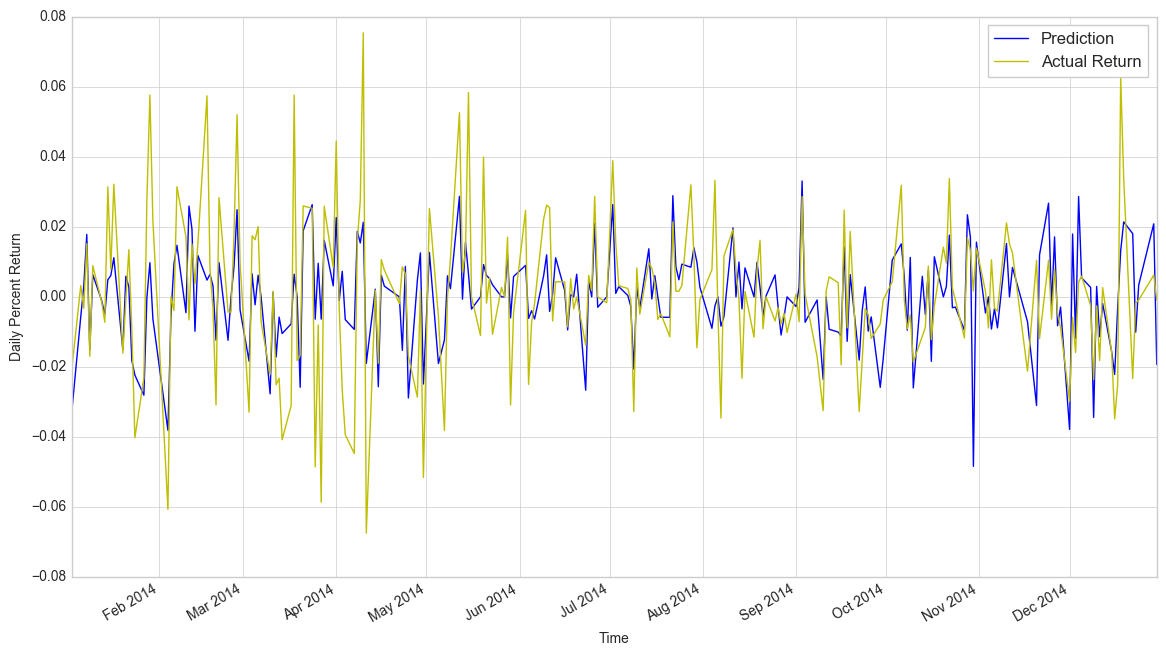

In [76]:
predictions = R_F + TENC_beta*(M - R_F) # CAPM equation

predictions.plot()
R.plot(color='Y')
plt.legend(['Prediction', 'Actual Return'])

plt.xlabel('Time')
plt.ylabel('Daily Percent Return');

In deriving the CAPM, we had to make two main assumptions:
- that investors are able to trade without delay or cost and that everyone is able to borrow or lend money at the risk free rate
- that all investors are "mean-variance optimizers", i.e. they only demand portfolios that have the highest return attainable for a given level of risk. Such portfolios lie along a curve known as the efficient frontier.

In [41]:
from scipy import optimize
import cvxopt as opt
from cvxopt import blas, solvers

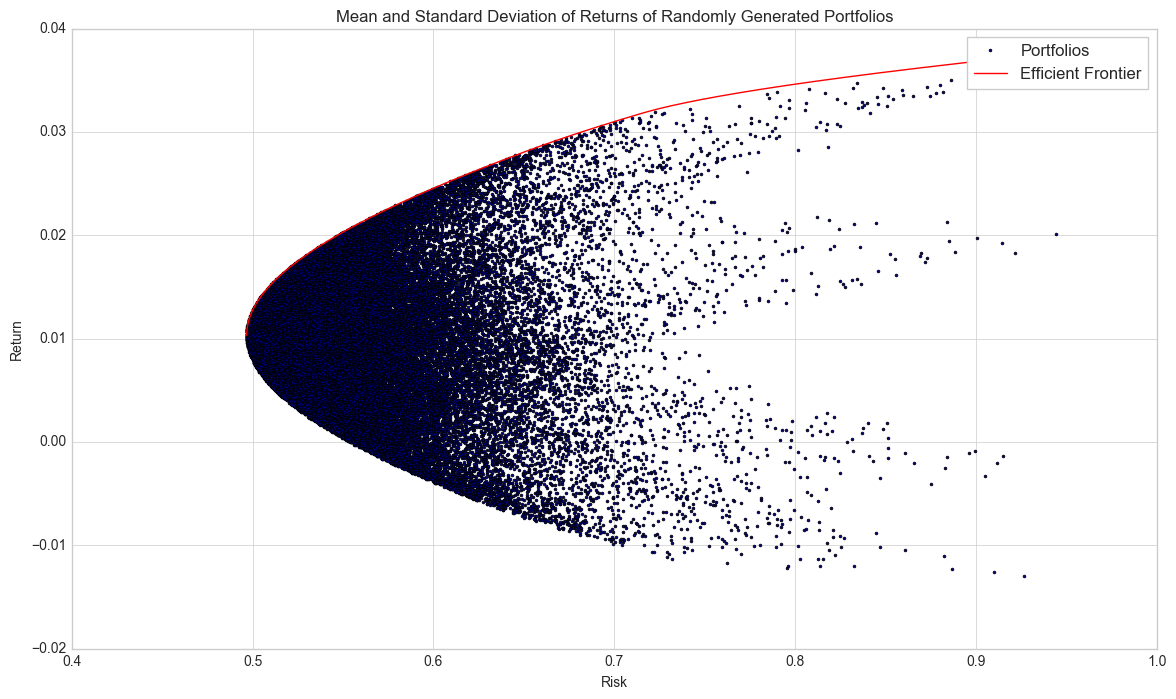

In [42]:
np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

# Number of assets
n_assets = 4

# Number of observations
n_obs = 2000

## Generating random returns for our 4 securities
return_vec = np.random.randn(n_assets, n_obs)

def rand_weights(n):
    ''' 
    Produces n random weights that sum to 1 
    '''
    k = np.random.rand(n)
    return k / sum(k)

def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

def optimal_portfolios(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100000
    
    # Creating a list of returns to optimize the risk for
    mus = [100**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    
    ## Calculate the risk and returns of the frontier
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    
    return returns, risks

n_portfolios = 50000

means, stds = np.column_stack([random_portfolio(return_vec) for x in range(n_portfolios)])

returns, risks = optimal_portfolios(return_vec)

plt.plot(stds, means, 'o', markersize=2, color='navy')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.title('Mean and Standard Deviation of Returns of Randomly Generated Portfolios');

plt.plot(risks, returns, '-', markersize=3, color='red');
plt.legend(['Portfolios', 'Efficient Frontier']);

The Capital Allocation Line (CAL) represents the portfolios consisting of all possible combinations of risk-free and risky assets. The slope of the CAL is the Sharpe ratio, and thus to maximise the Sharpe ratio, we need to find the steepest CAL, which coincides with the CAL that is tangential to the efficient frontier. This is why the efficient portfolio is sometimes referred to as the tangent portfolio.

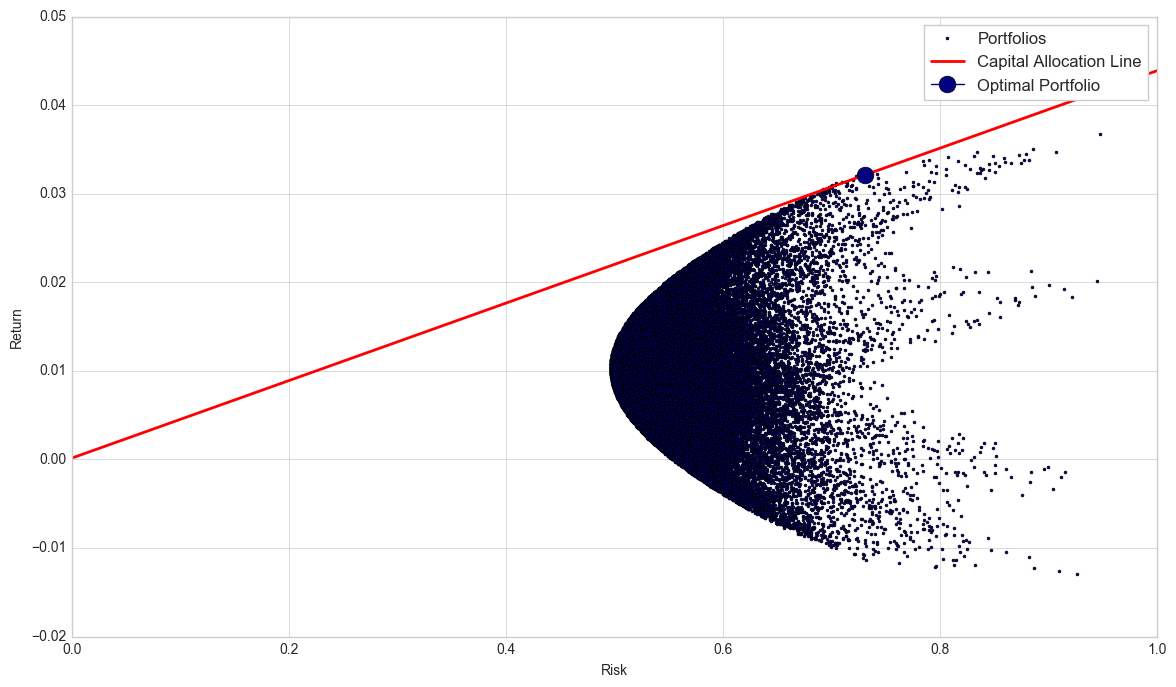

In [43]:
def maximize_sharpe_ratio(return_vec, risk_free_rate):
    """
    Finds the CAPM optimal portfolio from the efficient frontier 
    by optimizing the Sharpe ratio.
    """
    
    def find_sharpe(weights):
        means = [np.mean(asset) for asset in return_vec]
        numerator = sum(weights[m]*means[m] for m in range(len(means))) - risk_free_rate
        weight = np.array(weights)
        denominator = np.sqrt(weights.T.dot(np.corrcoef(return_vec).dot(weights)))
        
        return numerator/denominator
    
    guess = np.ones(len(return_vec)) / len(return_vec)
    
    def objective(weights):
        return -find_sharpe(weights)
    
    # Set up equality constrained
    cons = {'type':'eq', 'fun': lambda x: np.sum(np.abs(x)) - 1} 

    # Set up bounds for individual weights
    bnds = [(0, 1)] * len(return_vec)
    
    results = optimize.minimize(objective, guess,
                            constraints=cons, bounds=bnds, 
                            method='SLSQP', options={'disp': False})
    
    return results

risk_free_rate = np.mean(R_F)
results = maximize_sharpe_ratio(return_vec, risk_free_rate)

# Applying the optimal weights to each assset to get build portfolio
optimal_mean = sum(results.x[i]*np.mean(return_vec[i]) for i in range(len(results.x)))

optimal_std = np.sqrt(results.x.T.dot(np.corrcoef(return_vec).dot(results.x)))

# Plot of all possible portfolios
plt.plot(stds, means, 'o', markersize=2, color='navy')
plt.ylabel('Return')
plt.xlabel('Risk')

# Line from the risk-free rate to the optimal portfolio
eqn_of_the_line = lambda x : ( (optimal_mean-risk_free_rate) / optimal_std ) * x + risk_free_rate    

xrange = np.linspace(0., 1., num=11)

plt.plot(xrange, [eqn_of_the_line(x) for x in xrange], color='red', linestyle='-', linewidth=2)

# Our optimal portfolio
plt.plot([optimal_std], [optimal_mean], marker='o', markersize=12, color="navy")

plt.legend(['Portfolios', 'Capital Allocation Line', 'Optimal Portfolio']);

In [44]:
for a in range(len(return_vec)): 
    print "Return and Risk of Asset", a, ":", np.mean(return_vec[a]), ",",np.std(return_vec[a])   
    
print "Return and Risk of Optimal Portfolio", optimal_mean, optimal_std

Return and Risk of Asset 0 : -0.0155874843425 , 0.979925446819
Return and Risk of Asset 1 : 0.0384158887148 , 0.985658403299
Return and Risk of Asset 2 : 0.0206467377992 , 0.991949738581
Return and Risk of Asset 3 : -0.00443686547651 , 1.00311968218
Return and Risk of Optimal Portfolio 0.0321249501762 0.731407962629


When a risk-free asset is added to the portfolio, the Capital Asset Line turns into the Capital Market Line (CML). According to the CAPM, any stock or portfolio that lies to the right of CML would contain diversifiable risk and is therefore not efficient.

The mapping of each security's beta to its expected return results in the Security Markets Line. The difference between a security's return and the expected return as predicted by CAPM is known as the alpha.

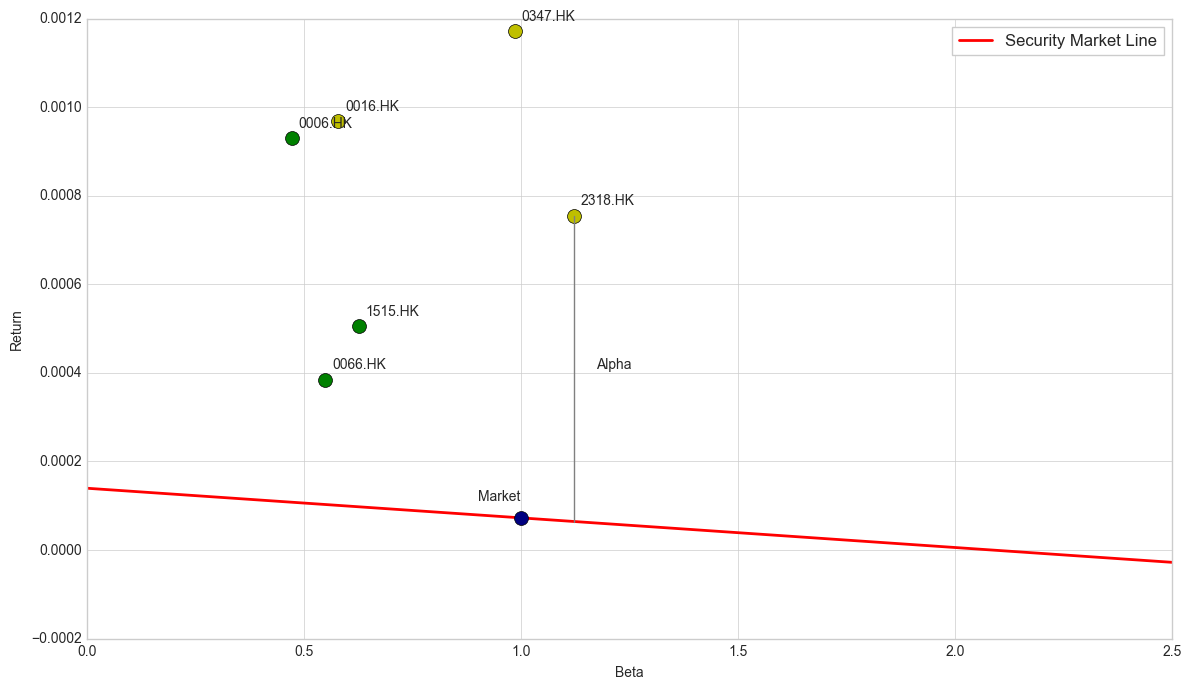

In [77]:
risk_free_rate = np.mean(R_F)

# We have two coordinates that we use to map the SML: (0, risk-free rate) and (1, market return)

eqn_of_the_line = lambda x : ( (np.mean(M)-risk_free_rate) / 1.0) * x + risk_free_rate        
xrange = np.linspace(0., 2.5, num=2)
plt.plot(xrange, [eqn_of_the_line(x) for x in xrange], color='red', linestyle='-', linewidth=2)

plt.plot([1], [np.mean(M)], marker='o', color='navy', markersize=10)
plt.annotate('Market', xy=(1, np.mean(M)), xytext=(0.9, np.mean(M)+0.00004))

# Next, we will compare to see whether stocks in more cyclical industries have higher betas
# Of course, a more thorough analysis is required to rigorously answer this question

# Non-Cyclical Industry Stocks
non_cyclical = ['0006.HK', '0066.HK', '1515.HK']
non_cyclical_returns = ut.get_pricing(
    non_cyclical,
    src='yhoo',
    start_date=start_date,
    end_date=end_date,
    field='close'
).dropna().pct_change()[1:]

non_cyclical_returns = non_cyclical_returns.reindex(M.index)

non_cyclical_betas = [
    regression.linear_model.OLS(
        non_cyclical_returns[asset],
        sm.add_constant(M)
    ).fit().params[1]
     for asset in non_cyclical
]

for asset, beta in zip(non_cyclical, non_cyclical_betas):
    plt.plot([beta], [np.mean(non_cyclical_returns[asset])], marker='o', color='g', markersize=10)
    plt.annotate(
        asset,
        xy=(beta, np.mean(non_cyclical_returns[asset])),
        xytext=(beta + 0.015, np.mean(non_cyclical_returns[asset]) + 0.000025)
    )

# Cyclical Industry Stocks
cyclical = ['0016.HK', '0347.HK', '2318.HK']
cyclical_returns = ut.get_pricing(
    cyclical,
    src='yhoo',
    start_date=start_date,
    end_date=end_date,
    field='close'
).dropna().pct_change()[1:]

cyclical_returns = cyclical_returns.reindex(M.index)

cyclical_betas = [
    regression.linear_model.OLS(
        cyclical_returns[asset],
        sm.add_constant(M)
    ).fit().params[1]
     for asset in cyclical
]

for asset, beta in zip(cyclical, cyclical_betas):
    plt.plot([beta], [np.mean(cyclical_returns[asset])], marker='o', color='y', markersize=10)
    plt.annotate(
        asset,
        xy=(beta, np.mean(cyclical_returns[asset])),
        xytext=(beta + 0.015, np.mean(cyclical_returns[asset]) + 0.000025)
    )

# drawing the alpha, which is the difference between expected return and the actual return
plt.plot(
    [cyclical_betas[2], cyclical_betas[2]],
    [np.mean(cyclical_returns.iloc[:, 2]), eqn_of_the_line(cyclical_betas[2])],
    color='grey'
)
plt.annotate(
    'Alpha',
    xy=(
        cyclical_betas[2] + 0.05,
        (eqn_of_the_line(cyclical_betas[2])-np.mean(cyclical_returns.iloc[:,2]))/2+np.mean(cyclical_returns.iloc[:,2])
    ),
    xytext=(
        cyclical_betas[2] + 0.05,
        (eqn_of_the_line(cyclical_betas[2])-np.mean(cyclical_returns.iloc[:,2]))/2+np.mean(cyclical_returns.iloc[:,2])
    )
)

plt.xlabel("Beta")
plt.ylabel("Return")

plt.legend(['Security Market Line']);

## Arbitrage pricing theory

The CAPM, while widely used and studied, has many drawbacks. With strict, limiting assumptions, it does not hold up well in empirical tests. The Arbitrage Pricing Theory (APT) aims to generalize the CAPM model, as assets may be exposed to classes of risks other than the market risk and investors may care about things other than just the mean and variance.

APT tries to express the returns of an asset using a linear factor model,
$$
R_i=a_i+b_{i_1}F_1+b_{i_2}F_2+...+b_{i_K}F_K+\epsilon_i\,,
$$
where each $F_i$ are known as *(risk) factors*: a return stream determined completely by some characteristic. For example, the market return is a factor. This gives an expected return of
$$
\mathbb{E}[R_i]=R_F+b_{i_1}\lambda_1+b_{i_2}\lambda_2+...+b_{i_K}\lambda_K\,,
$$
where $R_F$ is the risk-free rate, and $\lambda_j$ is the risk premium for factor $j$.

There are many ways to compute each $\lambda_j$. Since there are so many securities in our universe, there is no way to compute the $\{\lambda_i\}$ consistently. This creates an *arbitrage opportunity*: an opportunity to perform a risk-free operation that yields positive expected return without incurring risk and with no net investment. This is simply taking advantage of the fact that risk may not be priced consistently across securities.

For example, suppose we have an asset with expected rate of return 0.2 for the next year and a Beta of 1.2 with the market, while the market is expected to have a rate of return of 0.1, and the risk-free rate on 1-year bonds is 0.05. The APT model then tells us that the expected rate of return on the asset should be
$$
R_F+\beta\lambda=0.05+1.2(0.1-0.05)=0.11\neq0.2\,.
$$
Then if we buy \$100 of this asset, short \$120 of the market, and buy \$20 of bonds, we will have invested no net money and are not exposed to any systematic risk (we are market-neutral). But this gives an expected earnings of 0.2(100)-0.1(120)+0.05(20)=9 dollars at the end of the year.

The APT assumes that these opportunities will be taken advantage of until prices shift and the arbitrage opportunities disappear. That is, it assumes that there are arbitrageurs who have sufficient amounts of patience and capital. This provides a justification for the use of empirical factor models in pricing securities: if the model was inconsistent, there would be an arbitrage opportunity, and so the prices would adjust.

Of course, determining $\mathbb{E}[R_i]$ accurately is incredibly difficult, but this model tells us what the expected returns should be if the market is free of arbitrage. This lays the groundwork for strategies based on factor model ranking systems. Given a model for the expected return of an asset, we can rank the assets based on their expected performance and use this information to make trades. This is the basis behind the long-short equity strategy.

Let us now try to put our theory to test. We will use the *Fama-Macbeth regression* method to get our risk premiums for the factors. This simply consists of performing the following:
1. Regress each asset's returns against the proposed factors' return stream to determine that asset's beta for that factor, $$\begin{array}{ccc}
R_{1,t}&=&\alpha_1+\beta_{1,F_1}F_{1,t}+\beta_{1,F_2}F_{2,t}+...+\beta_{1,F_m}F_{m,t}+\epsilon_{1,t}\\
R_{2,t}&=&\alpha_2+\beta_{2,F_1}F_{1,t}+\beta_{2,F_2}F_{2,t}+...+\beta_{2,F_m}F_{m,t}+\epsilon_{2,t}\\
& & \vdots\\
R_{n,t}&=&\alpha_n+\beta_{n,F_1}F_{1,t}+\beta_{n,F_2}F_{2,t}+...+\beta_{n,F_m}F_{m,t}+\epsilon_{n,t}\\
\end{array}$$
2. Regress all asset returns for a fixed time period against the estimated betas to determine the risk premium $\gamma_K$ for each factor, $$\mathbb{E}[R_i]=\gamma_0+\gamma_1\hat{\beta}_{i,F_1}+\gamma_2\hat{\beta}_{i,F_2}+...+\gamma_m\hat{\beta}_{i,F_m}+\epsilon_i\,.$$

Note that Fama-MacBeth regressions provide standard errors corrected only for cross-sectional correlation. This means that the standard errors do not correct for time-series autocorrelation. This is fine for stocks trading since we are not holding them for a long time.

In [ ]:
# Code omitted as lack of fundamentals data source
#
# Essentially we rank equities based on their purchases of businesses, their R&D spending, and their cash flow, 
# to get the factor return streams.

# assets = list of assets
# data = returns + fundamentals data


# Long assets ranked highly and short those ranked lowly
biz_purchase_portfolio = most_biz_bought - least_biz_bought
RD_portfolio = most_RD - least_RD
cash_flow_portfolio = most_cash - least_cash

X = [data.xs(asset, level=1)['Returns'] for asset in assets] 
Y = [
    data.xs(asset, level=1)[['Purchase of Business', 'RD', 'Operating Cash Flow', 'const']]
     for asset in assets
]

# First regression step: estimating the betas
reg_results = [
    regression.linear_model.OLS(x-risk_free_rate, y).fit().params
     for x, y in zip(X, Y) if not(x.empty or y.empty)
]
indices = [asset for x, y, asset in zip(X, Y, assets) if not(x.empty or y.empty)]

betas = pd.DataFrame(reg_results, index=indices)
betas = sm.add_constant(betas.drop('const', axis=1))

R = data['Returns'].mean(axis=0, level=1)

# Second regression step: estimating the risk premia
final_results = regression.linear_model.OLS(R - risk_free_rate, betas).fit()
